# Fine-tuning a pretrained model

- How to prepare a large dataset

- How to use the high-level Trainer API to fine-tune a model


## Preparing your data

Training a sequence classifier on one batch:

In [ ]:
!pip install datasets evaluate transformers

In [ ]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

# This is new
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()

In [3]:
AdamW?

## SST Dataset

The Stanford Sentiment Treebank is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. 

The corpus is based on the dataset introduced by Pang and Lee (2005) and consists of 11,855 single sentences extracted from movie reviews. 

It was parsed with the Stanford parser and includes a total of 215,154 unique phrases from those parse trees, each annotated by 3 human judges.

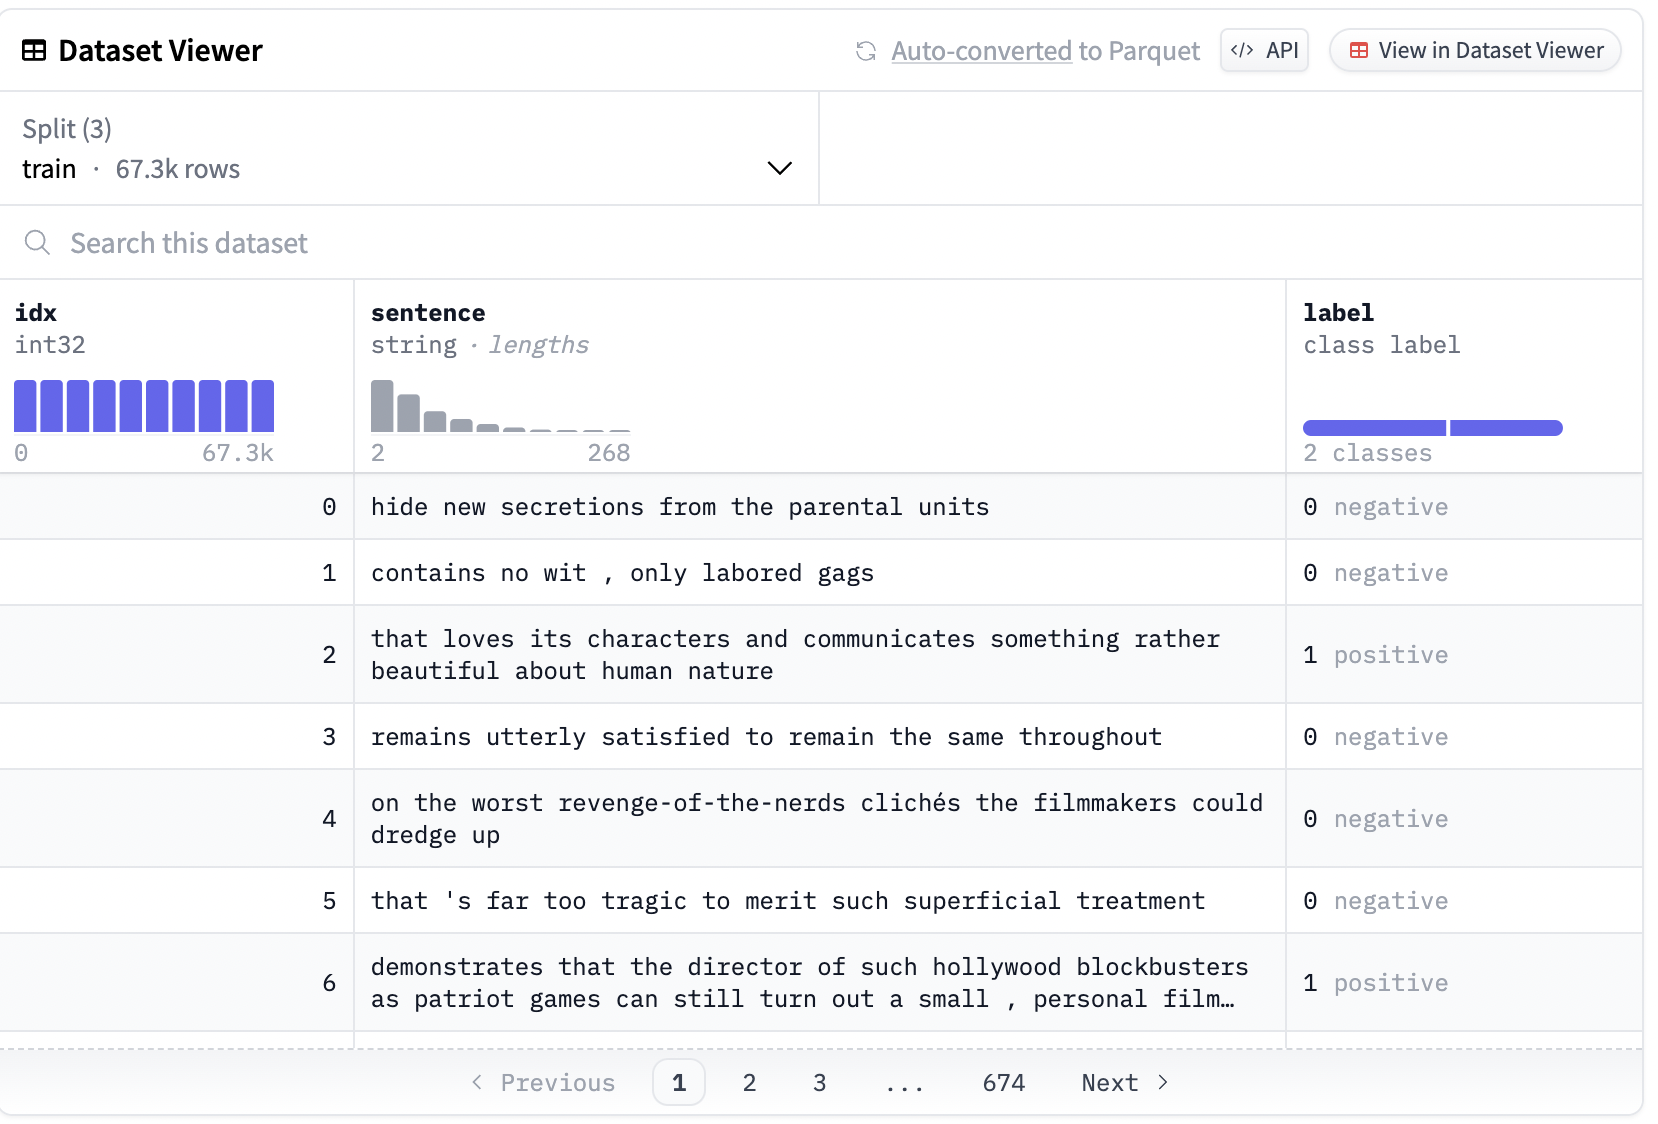

## Loading a Dataset

In [4]:
from datasets import load_dataset

raw_datasets = load_dataset("sst2")
raw_datasets

Found cached dataset parquet (/Users/psmith/.cache/huggingface/datasets/parquet/sst2-1151590ea3b3f98b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [5]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[6]

{'idx': 6,
 'sentence': 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
 'label': 1}

In [6]:
raw_train_dataset.features

{'idx': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None)}

## Preprocessing a dataset

Need to convert the text to numbers the model can make sense of: tokenize

In [7]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence"])

In [8]:
inputs = tokenizer("This is a sentence for training", "this is another")

In [9]:
inputs

{'input_ids': [101, 2023, 2003, 1037, 6251, 2005, 2731, 102, 2023, 2003, 2178, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]',
 'this',
 'is',
 'a',
 'sentence',
 'for',
 'training',
 '[SEP]',
 'this',
 'is',
 'another',
 '[SEP]']

In [11]:
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence"],
    padding=True,
    truncation=True,
)

This works well, but it has the disadvantage of returning a dictionary 

(with our keys, input_ids, attention_mask, and token_type_ids, and values that are lists of lists). 

It will also only work if you have enough RAM to store your whole dataset during the tokenization

To keep the data as a dataset, we will use the `Dataset.map()` method. 

This also allows us some extra flexibility, if we need more preprocessing done than just tokenization. 

The `map()` method works by applying a function on each element of the dataset, so let’s define a function that tokenizes our inputs:

In [12]:
def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

We apply the tokenization function on all our datasets at once. 

We’re using `batched=True` in our call to map so the function is applied to multiple elements of our dataset at once, and not on each element separately. 

This allows for faster preprocessing.

In [13]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Loading cached processed dataset at /Users/psmith/.cache/huggingface/datasets/parquet/sst2-1151590ea3b3f98b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-89e2cf7bb855ab9d.arrow


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/psmith/.cache/huggingface/datasets/parquet/sst2-1151590ea3b3f98b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-dcba659cc9f8600d.arrow


DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
})

## Dynamic padding

The function that is responsible for putting together samples inside a batch is called a collate function.

`DataCollatorWithPadding` takes a tokenizer when you instantiate it (to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs) and will do everything you need:

In [14]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Let’s grab a few samples from our training set that we would like to batch together. 

Here, we remove the columns `idx` and `sentence` as they won’t be needed and contain strings (and we can’t create tensors with strings) and have a look at the lengths of each entry in the batch:

In [15]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence"]}
[len(x) for x in samples["input_ids"]]

[10, 11, 15, 10, 22, 13, 29, 6]

Dynamic padding means the samples in this batch should all be padded to a length of 29

Without dynamic padding, all of the samples would have to be padded to the maximum length in the whole dataset, or the maximum length the model can accept.

Let's double check this:

In [16]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([8, 29]),
 'token_type_ids': torch.Size([8, 29]),
 'attention_mask': torch.Size([8, 29]),
 'labels': torch.Size([8])}

## Fine-tuning a model

🤗 Transformers provides a `Trainer` class to help you fine-tune any of the pretrained models it provides on your dataset

In [ ]:
!pip install accelerate -U

In [ ]:
!pip uninstall -y -r transformers accelerate
!pip install transformers==4.29.0
!pip install git+https://github.com/huggingface/accelerate

The first step before we can define our `Trainer` is to define a `TrainingArguments` class that will contain all the hyperparameters the `Trainer` will use for training and evaluation.

The only argument you have to provide is a directory where the trained model will be saved, as well as the checkpoints along the way

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

The second step is to define our model. 

We will use the AutoModelForSequenceClassification class, with two labels:

In [20]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

You get a warning after instantiating this pretrained model. 

This is because BERT has not been pretrained on classifying pairs of sentences, so the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead. 

The warnings indicate that some weights were not used (the ones corresponding to the dropped pretraining head) and that some others were randomly initialized (the ones for the new head). 

It concludes by encouraging you to train the model, which is exactly what we are going to do now.

In [21]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

To fine-tune the model on our dataset, we just have to call the `train()` method of our `Trainer`:

In [23]:
trainer.train()

Step,Training Loss
500,0.425700
1000,0.385800
1500,0.366300
2000,0.347400
2500,0.352000
3000,0.311700
3500,0.320200
4000,0.292900


KeyboardInterrupt: 

This will start the fine-tuning (which should take a couple of minutes on a GPU) and report the training loss every 500 steps. It won’t, however, tell you how well (or badly) your model is performing. This is because:

1. We didn’t tell the `Trainer` to evaluate during training by setting evaluation_strategy to either "steps" (evaluate every eval_steps) or "epoch" (evaluate at the end of each epoch).
2. We didn’t provide the `Trainer` with a `compute_metrics()` function to calculate a metric during said evaluation (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).


## Evaluation

Let’s see how we can build a useful `compute_metrics()` function and use it the next time we train. 

The function must take an `EvalPrediction` object (which is a named tuple with a predictions field and a label_ids field) and will return a dictionary mapping strings to floats (the strings being the names of the metrics returned, and the floats their values). 

To get some predictions from our model, we can use the `Trainer.predict()` command:

In [33]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(872, 2) (872,)


The output of the `predict()` method is another named tuple with three fields: `predictions`, `label_ids`, and `metrics`.

The metrics field will just contain the loss on the dataset passed, as well as some time metrics (how long it took to predict, in total and on average). 

Once we complete our compute_metrics() function and pass it to the Trainer, that field will also contain the metrics returned by compute_metrics().

In [34]:
print(predictions)

PredictionOutput(predictions=array([[-2.1370733 ,  2.1313248 ],
       [ 1.5652556 , -2.913611  ],
       [-2.1364074 ,  2.13067   ],
       ...,
       [-0.1900532 , -1.3731203 ],
       [ 0.94517905, -2.3707874 ],
       [-2.128066  ,  2.1211069 ]], dtype=float32), label_ids=array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0

`Predictions` is a two-dimensional array with shape 872 x 2 (872 being the number of elements in the dataset we used). 

Those are the logits for each element of the dataset we passed to `predict()` 

To transform them into predictions that we can compare to our labels, we need to take the index with the maximum value on the second axis:

In [35]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)
print(preds)

[1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1
 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1
 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0
 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0
 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0
 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0
 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1
 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1
 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1
 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1
 0 1 1 1 1 0 0 1 0 0 0 1 

We can now compare those preds to the labels. 

To build our `compute_metric()` function, we will rely on the metrics from the 🤗 `Evaluate` library. 

We'll use one of our favourite metrics for evaluation

The object returned has a `compute()` method we can use to do the metric calculation:

In [41]:
import evaluate

metric = evaluate.load("accuracy")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8887614678899083}

In the BERT paper the accuracy is reported as 0.884 with a base bert model, so we're doing well here for some very basic pre-training!

Let's now combine all into a function:

In [31]:
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

To see it used in action to report metrics at the end of each epoch, here is how we define a new `Trainer` with this `compute_metrics()` function:

In [42]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

And now we train with everything:

In [43]:
trainer.train()

/Users/psmith/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Summary

- Learned about datasets in the Hub
- Learned how to load and preprocess datasets, including using dynamic padding and collators
- Implemented your own fine-tuning and evaluation of a model


# Hopefully you've enjoyed learning about NLP.


# Good luck for the future!